<a href="https://colab.research.google.com/github/StasNesterov13/SymbolRegression/blob/main/SymbolicRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sympy import symbols, lambdify, simplify
from numpy import log, exp
from scipy.stats import truncnorm
import warnings
from sys import set_int_max_str_digits
set_int_max_str_digits(40000)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# функция приспособленности
def fitness(pop):
    f = lambdify(x, function(pop))
    return sum((f1 - f(x1)) ** 2)

In [ ]:
# создание хромосомы
def chrome(l):
    stroka = []
    t = 0
    while len(stroka) < l or t != 1:
        if t < 1:
            r = random.choice(operand)
            t += 1
            r = str(random.uniform(-10, 10)) if r == "y" else r
            stroka.append(r)
        elif t < 2:
            un = random.choice(operator_un)
            oper = random.choice(operand)
            r = np.random.choice([un, oper], p=[0.3, 0.7])
            t = t + 1 if r in operand else t + 0
            r = str(random.uniform(-10, 10)) if r == "y" else r
            stroka.append(r)
        else:
            bin = random.choice(operator_bin)
            un = random.choice(operator_un)
            oper = random.choice(operand)
            r = np.random.choice([bin, un, oper], p=[0.5, 0.3, 0.2])
            t = t + 1 if r in operand else t - 1 if r in operator_bin else t + 0
            r = str(random.uniform(-10, 10)) if r == "y" else r
            stroka.append(r)
    if len(stroka) > l + 10:
      stroka = chrome(l)
    return stroka

In [ ]:
# инфиксная запись
def function(stroka):
    stack = []
    for i in stroka:
        if i in operator_bin:
            stack.append("(" + stack[-1] + i + stack[-2] + ")")
            stack.remove(stack[-3])
            stack.remove(stack[-2])
        elif i in operator_un:
            stack[-1] = "(" + stack[-1] + ")"
            stack.append("-" + stack[-1])
            stack.remove(stack[-2])
        else:
            stack.append(i)
    stack[-1] = stack[-1].replace("^", "**")
    return stack[-1]

In [ ]:
# создание подходящей хромомосомы
def create_population(l):
    c = chrome(l)
    try:
        if np.isinf(fitness(c)) or np.isnan(fitness(c)) or np.iscomplex(fitness(c)):
            c = create_population(l)
    except KeyError:
        c = create_population(l)
    except OverflowError:
        c = create_population(l)
    return c

In [ ]:
# список функций приспособленности
def list_fitness():
    return [fitness(i) for i in population]

In [ ]:
# селекция
def selection(list_fit, num=25):
    best_pop = []
    for i in range(num):
        best_pop.append(population[np.where(list_fit == sorted(list_fit)[i])[0][0]])
    return best_pop

In [ ]:
# нахождение худших хромосом
def selection_bad(list_fit):
    bad_num = []
    for i in range(-1, -11, -1):
        bad_num.append(np.where(list_fit == sorted(list_fit)[i])[0][0])
    return bad_num

In [ ]:
# скрещивание
def undertrees(ax):
    stack = []
    stack_tree = []
    indexes = []
    if len(ax) == 1:
        stack_tree.append(ax)
        indexes.append(0)
    else:
        for i in range(len(ax)):
            if ax[i] in operator_bin:
                stack.append(stack[-2] + stack[-1] + [ax[i]])
                stack.remove(stack[-3])
                stack.remove(stack[-2])
                stack_tree.append(stack[-1])
                indexes.append(i - len(stack[-1]) + 1)
            elif ax[i] in operator_un:
                stack.append(stack[-1] + ["-"])
                stack.remove(stack[-2])
                stack_tree.append(stack[-1])
                indexes.append(i - len(stack[-1]) + 1)
            else:
                stack.append([ax[i]])
    return (indexes, stack_tree)


def cross(select):
    kids = []
    for i in range(10):
        par1, par2 = random.choice(select), random.choice(select)
        ind1, tree1 = undertrees(par1)
        ind2, tree2 = undertrees(par2)
        bp1 = random.randint(0, len(tree1) - 1)
        bp2 = random.randint(0, len(tree2) - 1)
        kid1 = par1[: ind1[bp1]] + tree2[bp2] + par1[ind1[bp1] + len(tree1[bp1]) :]
        kid2 = par2[: ind2[bp2]] + tree1[bp1] + par2[ind2[bp2] + len(tree2[bp2]) :]
        kids.append(random.choice([kid1, kid2]))
    return kids


In [ ]:
# мутация
def mut1(kid):
    kid_copy = kid.copy()
    try:
        i = random.randint(0, len(kid) - 1)
        d = [j in operator_bin for j in kid]
        if sum(d):
            while kid[i] not in operator_bin:
                i = random.randint(0, len(kid) - 1)
            temp_copy = operator_bin.copy()
            temp_copy.remove(kid[i])
            kid[i] = random.choice(temp_copy)
        else:
            return 0
        if (
            np.isinf(fitness(kid))
            or np.isnan(fitness(kid))
            or np.iscomplex(fitness(kid))
        ):
            kid = mutation_choice(kid_copy)
    except KeyError:
        kid = mutation_choice(kid_copy)
    except OverflowError:
        kid = mutation_choice(kid_copy)
    return kid


def mut2(kid):
    kid_copy = kid.copy()
    try:
        ind, tree = undertrees(kid)
        bp = random.randint(0, len(tree) - 1)
        new_tree = chrome(5)
        kid = kid[: ind[bp]] + new_tree + kid[ind[bp] + len(tree[bp]) :]
        if (
            np.isinf(fitness(kid))
            or np.isnan(fitness(kid))
            or np.iscomplex(fitness(kid))
        ):
            kid = mutation_choice(kid_copy)
    except KeyError:
        kid = mutation_choice(kid_copy)
    except OverflowError:
        kid = mutation_choice(kid_copy)
    return kid


def mut3(kid):
    kid_copy = kid.copy()
    try:
        d = [j in operator_un for j in kid]
        if sum(d):
            i = random.randint(0, len(kid) - 1)
            while kid[i] not in operator_un:
                i = random.randint(0, len(kid) - 1)
            kid.pop(i)
        else:
            return 0
        if (
            np.isinf(fitness(kid))
            or np.isnan(fitness(kid))
            or np.iscomplex(fitness(kid))
        ):
            kid = mutation_choice(kid_copy)
    except KeyError:
        kid = mutation_choice(kid_copy)
    except OverflowError:
        kid = mutation_choice(kid_copy)
    return kid


def mut4(kid):
    def isDigit(x):
        try:
            float(x)
            return True
        except ValueError:
            return False

    kid_copy = kid.copy()
    try:
        i = random.randint(0, len(kid) - 1)
        d = [isDigit(j) for j in kid]
        if sum(d):
            while not isDigit(kid[i]):
                i = random.randint(0, len(kid) - 1)
            kid[i] = str(random.uniform(-10, 10))
        else:
            return 0
        if (
            np.isinf(fitness(kid))
            or np.isnan(fitness(kid))
            or np.iscomplex(fitness(kid))
        ):
            kid = mutation_choice(kid_copy)
    except KeyError:
        kid = mutation_choice(kid_copy)
    except OverflowError:
        kid = mutation_choice(kid_copy)
    return kid

In [ ]:
# выбор мутации
def mutation_choice(kid):
    choice = np.random.choice([1, 2, 3, 4], p=[0.2, 0.4, 0.1, 0.3])
    if choice == 1:
        kid_mut = mut1(kid)
    elif choice == 2:
        kid_mut = mut2(kid)
    elif choice == 3:
        kid_mut = mut3(kid)
    else:
        kid_mut = mut4(kid)
    if kid_mut == 0:
        kid_mut = mutation_choice(kid)
    if len(kid_mut) > m + 20:
        kid_mut = mutation_choice(kid)
    return kid_mut


In [ ]:
# создание новой популяции
def new_population(population):
    list_fit = list_fitness()
    print(sorted(list_fit)[0])
    error.append(sorted(list_fit)[0])
    select = selection(list_fit)
    select_bad = selection_bad(list_fit)
    kids = cross(select)
    for i in range(len(select_bad)):
        kids[i] = mutation_choice(kids[i])
        population.append(create_population(m))
        population.append(kids[i])
    return population

In [ ]:
x, y = symbols("x, y")
x1 = np.array(sorted(np.random.uniform(-10, 10, 100)))
f1 = np.array(x1 ** 2 - 2 * x1 + 3) + np.random.normal(0, 1, 100)
operand = ["x", "y"]
operator_bin = ["*", "^", "+"]
operator_un = ["-"]

In [ ]:
N = 100 #размер популяции
m = 10 #количество генов в хромомсоме
k = 100 #максимальное количество итераций
error=[]
population = [create_population(m) for i in range(N)]

In [ ]:
for i in range(k):
  population = selection(list_fitness(), 100)
  population = new_population(population)
print(simplify(function(selection(list_fitness())[0])))

89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
89.28312325032773
x**2 - 2*x + 3.029808676502828


x**2 - 2*x + 3.029808676502828


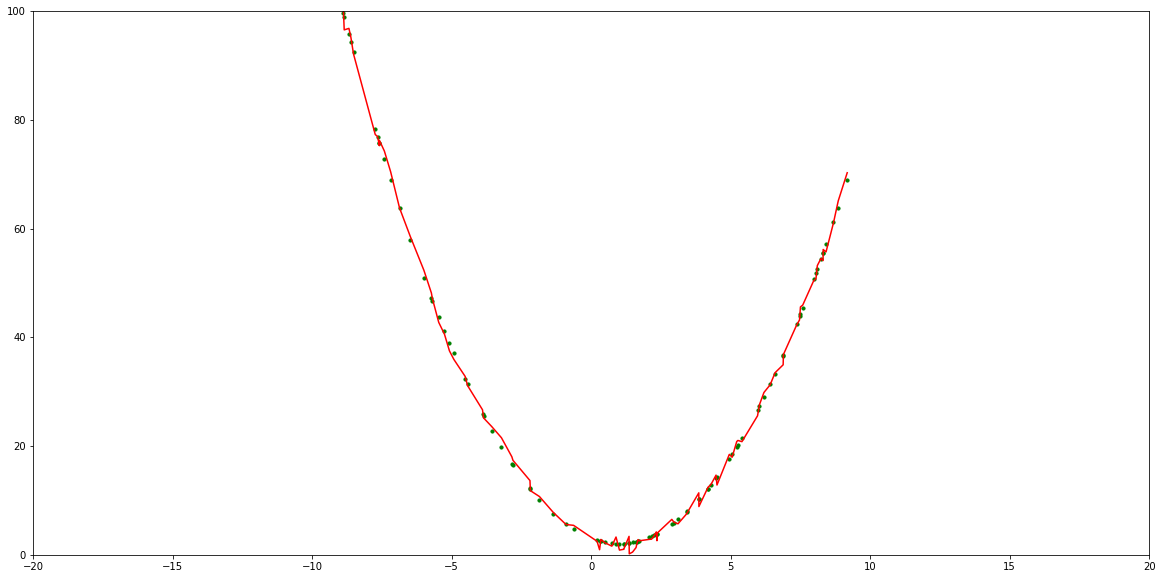

In [ ]:
f2 = lambdify(x, function(selection(list_fitness())[0]))
plt.figure(figsize=(20,10))
plt.scatter(x1, f2(x1), color='green',s=10)
plt.plot(x1, f1, color='red')
plt.gca().set(xlim=(-20, 20), ylim=(0, 100))
print(simplify(function(selection(list_fitness())[0])))

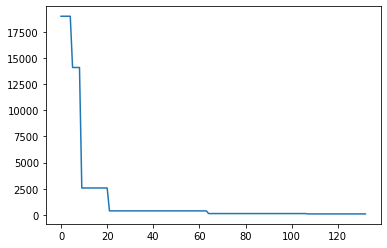

In [ ]:
plt.plot(range(len(error)),error)